# CriticalEarth Workshop 1, Project 1: Cessi model of the AMOC
## Group 2: Clara Hummel, Oisin Hamilton, Sacha Sinet, Kolja Kypke

In [1]:
#import relevant packages
import numpy as np
import scipy.integrate as integrate
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import PyDSTool as dst

## PART A (mandatory)
### (i) see report
### (ii) Write a Python program to integrate $\frac{dy}{dt} = F-y(1+\mu(1-y)^2$ in time given initial conditions $y(t=0)=y_0$.

In [2]:
#set parameter values and time array
F=1.1                               # freshwater flux parameter
mu=6.2                              # ratio of the diffusion and the advective time scale

t=np.linspace(0,6)                  # array of time points

In [3]:
y0=1.1                              # set initial condition

In [4]:
def dy(y,t,p=(F,mu)):               # RHS of the ODE with parameters F and mu
    return p[0]-y*(1+p[1]*(1-y)**2)

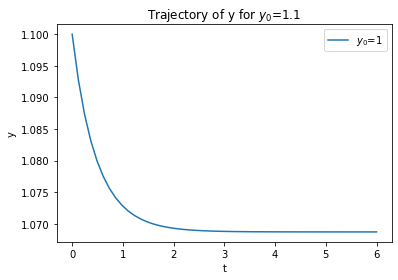

In [5]:
sol=odeint(dy,y0,t)                 # Solve the ODE for the given initial condition       
 
plt.plot(t,sol, label = "$y_0$=1")  # plot the solution

#define plot appearance
plt.xlabel("t")
plt.ylabel("y")
plt.title("Trajectory of y for $y_0$={}".format(y0))
plt.legend();

### (iii) Show numerically that for $F=1.1$, there exist at least two steady states of the model. 
We integrate the ODE for different initial conditions:

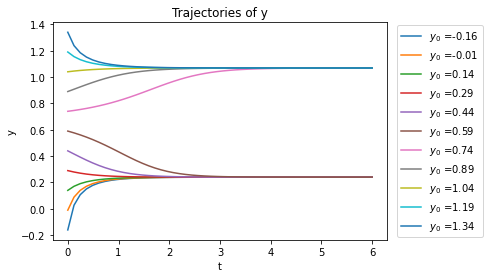

In [6]:
ivs=np.arange(-0.16,1.46,step=0.15)                      # array of initial values
for iv in ivs:                                          
    sol=odeint(dy,iv,t)                                  # calculate the solution for every initial condition
    plt.plot(t,sol,label = "$y_0$ ={:.2f}".format(iv))   # plot solutions

#define plot appearance
plt.xlabel("t")
plt.ylabel("y")
plt.title("Trajectories of y")
plt.legend(loc="right",bbox_to_anchor=(0.8, 0., 0.5, 1.0));

As it can clarly be seen in the plot above, the trajectories tend towards 2 steady states for various initial conditions.

### (iv) Compute the bifurcation diagram of the ODE with F as control parameter and determine the values of F at the saddle-node bifurcations, for example using the PyDSTool package.

This part has been adapted from the tutorial https://pydstool.github.io/PyDSTool/Tutorial/Tutorial_Calcium.html.

In [7]:
#set up the equation, parameters and initial conditions
DSargs = dst.args(name='AMOC model')            # give a name to the model
DSargs.pars = { 'F': 1.1,'mu': 6.2}             # parameters
DSargs.varspecs = {'y': 'F-y*(1+mu*(1-y)**2)'}  # RHS of the ODE
DSargs.ics      = {'y': 1}                      # initial conditions

In [8]:
DSargs.tdomain = [0,30]                         # set the range of integration (take 30 time points to assure convergence)
ode  = dst.Generator.Vode_ODEsystem(DSargs)     # set up ODE as an instance of the 'Generator' class.

In [9]:
# Prepare the system to start close to a steady state
ode.set(pars = {'F': -0.5} )                   # Lower bound of the control parameter 'F'
ode.set(ics =  {'y': -0.1} )                   # Close to one of the steady states present for F=-0.5

PC = dst.ContClass(ode)                        # Set up continuation class

PCargs = dst.args(name='AMOC model', type='EP-C')     # 'EP-C' stands for Equilibrium Point Curve. The branch will be labeled 'EQ1'.
PCargs.freepars     = ['F']                    # control parameter F, which is among those specified in DSargs.pars
PCargs.MaxNumPoints = 100                      # The following 3 parameters are set after trial-and-error
PCargs.MaxStepSize  = 0.05
PCargs.MinStepSize  = 1e-5
PCargs.StepSize     = 2e-2
PCargs.LocBifPoints = 'LP'                     # detect limit points / saddle-node bifurcations
PCargs.SaveEigen    = True                     # to tell unstable from stable branches

LP Point found 
LP Point found 


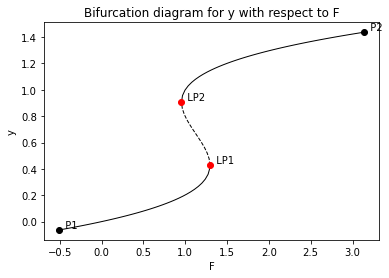

In [10]:
PC.newCurve(PCargs)
PC['AMOC model'].forward()
PC.display(['F','y'], stability=True, figure=3)        # stable and unstable branches as solid and dashed curves, resp.

#set plot appearance
plt.xlabel("F")
plt.ylabel("y")
plt.title("Bifurcation diagram for y with respect to F");

In [11]:
print("Limit point LP1 at F={:.2f} and y={:.2f}".format(PC['AMOC model'].getSpecialPoint('LP1')["F"],PC['AMOC model'].getSpecialPoint('LP1')["y"]))
print("Limit point LP2 at F={:.2f} and y={:.2f}".format(PC['AMOC model'].getSpecialPoint('LP2')["F"],PC['AMOC model'].getSpecialPoint('LP2')["y"]))

Limit point LP1 at F=1.30 and y=0.43
Limit point LP2 at F=0.96 and y=0.91


## PART B (optional)

We consider the extended nonlinear stochastic Stommel model where the freshwater forcing has a transient and stochastic component given by
\begin{align}
dY_t &= (\bar{F} - Y_t(1+ \mu (1- Y_t)^2))dt + \bar{F} dZ_t\\
dZ_t &= g(t)dt + \sigma dW_t,
\end{align}
where $g(t)$ describes a time dependence of the freshwater forcing, $\bar{F}$ the reference value of $F$, $\sigma$ represents the noise amplitude and $W_t$ is a Wiener process.

### v) Write a Python program to integrate the system of SDEs using the EulerMaruyama (EM) scheme. Determine a solution of the equations for $\bar{F} = 1.1$, $\sigma = 0.1$, $\mu = 6.2$ and $g(t) = 0$. Make a plot of the probability density function for this case.
In this case the SDEs simplify to the equation
$$
dY_t = (\bar{F} - Y_t(1+ \mu (1- Y_t)^2))dt + \bar{F} \sigma dW_t
$$

This part has been adapted from the tutorial https://ipython-books.github.io/134-simulating-a-stochastic-differential-equation/.

In [12]:
#set the parameters
F=1.1        # freshwater forcing
sigma = 0.1  # standard deviation
mu = 6.2     # mean

tau = .05    # time constant

In [13]:
#set simulation parameters
dt = .01                   # time step
T = 10.                    # total time.
n = int(T / dt)            # number of time steps
t = np.linspace(0., T, n)  # array of times

In [14]:
#define square root of dt
sqrtdt = np.sqrt(dt)

Calculate and plot trajectory of the process with $\bar{F} = 1.1$, $\sigma = 0.1$, $\mu = 6.2$ and $g(t) = 0$ for initial condition $y_0 = 0$:

In [15]:
x = np.zeros(n)            #vector containing all successive values of the process during the simulation
#simulate the process with the EM scheme
for i in range(n - 1):
    x[i+1] = x[i] + (F-x[i]*(1+mu*(1-x[i])**2))*dt + F*sigma*sqrtdt*np.random.randn()

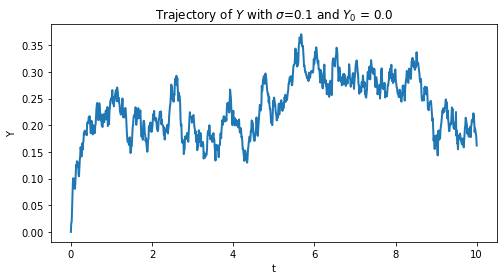

In [16]:
#plot time evolution
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(t, x, lw=2)
plt.xlabel("t")
plt.ylabel("Y")
plt.title("Trajectory of $Y$ with $\sigma$={} and $Y_0$ = {}".format(sigma,x[0]));

Calculate and plot trajectories for different initial values:

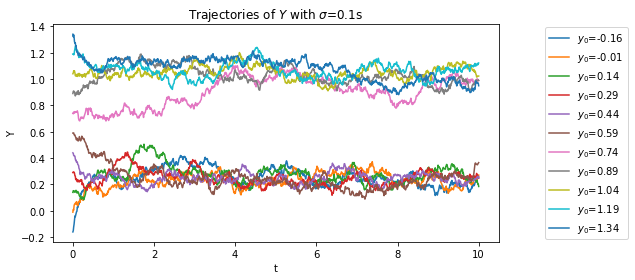

In [17]:
sigma=0.1


ivs=np.arange(-0.16,1.46,step=0.15)                   # array of initial conditions

fig, ax = plt.subplots(1, 1, figsize=(8, 4))          # initialize plot

for k,iv in enumerate(ivs):
    x = np.ones(n)*iv                                 # set initial condition
    
    #simulate the process with the EM scheme
    for i in range(n - 1):
        x[i+1] = x[i] + (F-x[i]*(1+mu*(1-x[i])**2))*dt + F*sigma*sqrtdt*np.random.randn()
    
    ax.plot(t,x,label = "$y_0$={:.2f}".format(iv))    #plot the trajectories

#set plot appearance
plt.xlabel("t")
plt.ylabel("Y")
plt.title("Trajectories of $Y$ with $\sigma$={}s".format(sigma))
plt.legend(loc="right",bbox_to_anchor=(0.8, 0., 0.5, 1.0));

Calculate the probability density function.
We do this by running a long time series and creating a histogram of the observed values of $Y$.

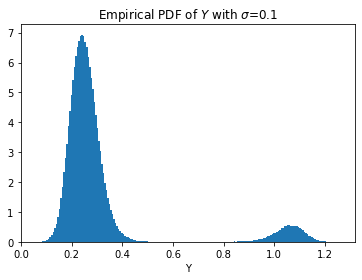

In [18]:
sigma=0.1
T = 10000.                    # Adjust total time to get usable time series
n = int(T / dt)               # recalculate number of time steps
t = np.linspace(0., T, n)     # reset vector of times


x1=np.ones(n)                  # vector containing all successive values of the process during the simulation, and sets Y_0=1.0
#simulate the process with the EM scheme
for i in range(n - 1):
    x1[i+1] = x1[i] + (F-x1[i]*(1+mu*(1-x1[i])**2))*dt + F*sigma*sqrtdt*np.random.randn();

#plot the histogram
plt.hist(x1,bins=200,density=True,label="empirical, T={}".format(T))
plt.title("Empirical PDF of $Y$ with $\sigma$={}".format(sigma))
plt.xlabel("Y");

Recalculate trajectories and the probability density function for more noise ($\sigma = 0.5$):

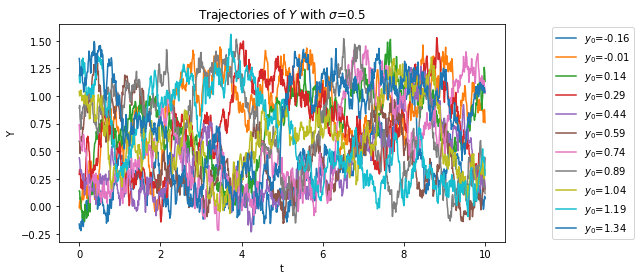

In [19]:
#Trajectories for different IVs but with more noise (sigma = 0.5)
sigma = 0.5                                           # Set different value for sigma

T = 10.                                               # total time.
n = int(T / dt)                                       # number of time steps
t = np.linspace(0., T, n)                             # array of times

fig, ax = plt.subplots(1, 1, figsize=(8, 4))          # initialize plot

for k,iv in enumerate(ivs):
    x = np.ones(n)*iv                                 # vector containing all successive values of the process during the simulation, and sets Y_0=1.0
    for i in range(n - 1):
        x[i+1] = x[i] + (F-x[i]*(1+mu*(1-x[i])**2))*dt + F*sigma*sqrtdt*np.random.randn()
    ax.plot(t,x,label = "$y_0$={:.2f}".format(iv))    # plot the trajectories

plt.xlabel("t")
plt.ylabel("Y")
plt.title("Trajectories of $Y$ with $\sigma$={}".format(sigma))
plt.legend(loc="right",bbox_to_anchor=(0.8, 0., 0.5, 1.0));

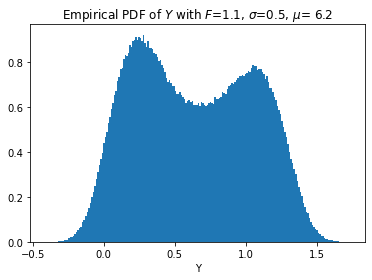

In [20]:
#PDF for sigma = 0.5
sigma = 0.5                   # Change standard deviation

T = 10000.                    # Adjust total time to get usable time series
n = int(T / dt)               # recalculate number of time steps
t = np.linspace(0., T, n)     # reset vector of times



x2=np.ones(n)
for i in range(n - 1):
    x2[i+1] = x2[i] + (F-x2[i]*(1+mu*(1-x2[i])**2))*dt + F*sigma*sqrtdt*np.random.randn();

plt.hist(x2,bins=200,density=True,label="empirical, T={}".format(T))
plt.title("Empirical PDF of $Y$ with $F$={}, $\sigma$={}, $\mu$= {}".format(F,sigma,mu))
plt.xlabel("Y");

### (vi) Determine the equilibrium solution of the Fokker-Plank equation for this case analytically, and compare the result with that in (v).

Fokker-Plank equation:

In [21]:
y=np.arange(0,1.3,step=0.01)       # range of Y
#analytical solution of the Fokker-Plank equation for fixed sigma, with given normalization coefficient
def FP_expr(y,c,sigma,t=0):          
    sol=c*np.exp((y*(12*F - 6*y + 12*t - 6*y*mu + 8*y**2*mu - 3*y**3*mu))/(6*F**2*sigma**2))
    return sol

In [22]:
def FP(y,sigma,t):                  # Fokker-Plank equation with calculated normalization coefficient for given sigma and time
    c=1/(integrate.quad(lambda x: FP_expr(x,1,sigma,t),-10,10))[0]
    sol=FP_expr(y,c,sigma,t)
    return sol

Plot Fokker-Plank equation for $\sigma=0.1$ and compare with the probability density function:

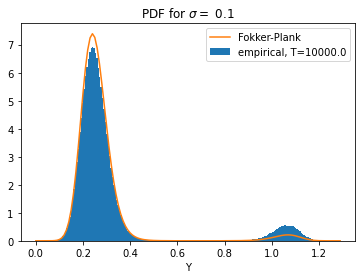

In [23]:
sigma=0.1                 #set sigma
plt.hist(x1,bins=200,density=True,label="empirical, T={}".format(T))
plt.plot(y,FP(y,sigma,0), label = "Fokker-Plank")  
plt.xlabel("Y")
plt.title("PDF for $\sigma =$ {}".format(sigma))
plt.legend();

Plot Fokker-Plank equation for $\sigma=0.5$ and compare with the probability density function:

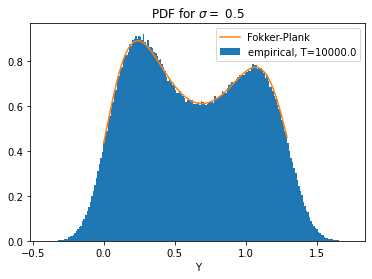

In [24]:
sigma=0.5        #set sigma
plt.hist(x2,bins=200,density=True,label="empirical, T={}".format(T))
plt.plot(y,FP(y,sigma,0), label = "Fokker-Plank")  
plt.xlabel("Y")
plt.title("PDF for $\sigma =$ {}".format(sigma))
plt.legend();

### (vii) Consider the stochastic case with $g(t)=\varepsilon t$ and $\varepsilon = 0.001$. Study the behaviour of the model for increasing noise amplitude (again with $\bar{F} = 1.1$ and $\mu = 6.2$). What type of tipping occurs when $\sigma$ increases?

We look at the SDE
$$
dY_t = \left[-Y_t(1+ \mu (1- Y_t)^2) + \bar{F}(1+\varepsilon t)\right]dt + \bar{F} \sigma dW_t
$$

In [25]:
eps=0.001

Calculate and plot trajectory for $\sigma = 0.1$ and $y_0 = 0$

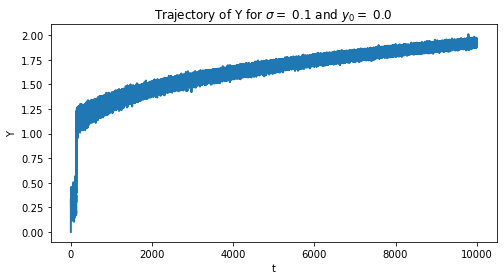

In [26]:
sigma=0.1
x=np.zeros(n)
for i in range(n - 1):
    x[i+1] = x[i] + (F-x[i]*(1+mu*(1-x[i])**2))*dt \
    + F*eps*t[i]*dt \
    + F*sigma*sqrtdt*np.random.randn()
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(t, x, lw=2)
plt.xlabel("t")
plt.ylabel("Y")
plt.title("Trajectory of Y for $\sigma =$ {} and $y_0 = $ {}".format(sigma,x[0]));

Calculate and plot trajectory for $\sigma = 0.1$ and various initial conditions

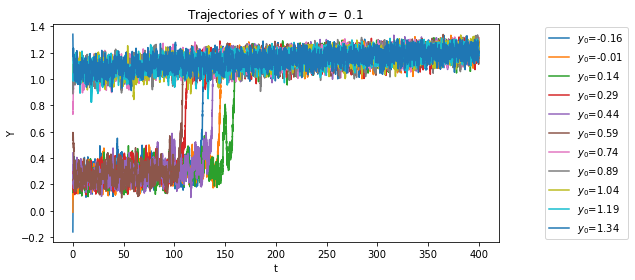

In [27]:
sigma = 0.1 

T = 400.  # Total time.
n = int(T / dt)  # Number of time steps.
t = np.linspace(0., T, n)  # Vector of times.

fig, ax = plt.subplots(1, 1, figsize=(8, 4))          # initialize plot


ivs = np.arange(-0.16,1.46,step=0.15)
for k,iv in enumerate(ivs):
    x = np.ones(n)*iv
    for i in range(n - 1):
        x[i+1] = x[i] + (F-x[i]*(1+mu*(1-x[i])**2))*dt \
            + F*eps*t[i]*dt \
            + F*sigma*sqrtdt*np.random.randn()
    plt.plot(t,x,label = "$y_0$={:.2f}".format(iv))

plt.xlabel("t")
plt.ylabel("Y")
plt.title("Trajectories of Y with $\sigma=$ {}".format(sigma))
plt.legend(loc="right",bbox_to_anchor=(0.8, 0., 0.5, 1.0));

Calculate and plot trajectory for $\sigma = 0.2$ and various initial conditions

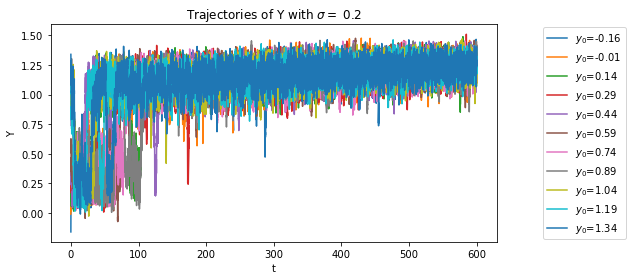

In [28]:
sigma = 0.2  # Standard deviation

T = 600.  # Total time.
n = int(T / dt)  # Number of time steps.
t = np.linspace(0., T, n)  # Vector of times.

fig, ax = plt.subplots(1, 1, figsize=(8, 4))          # initialize plot

ivs = np.arange(-0.16,1.46,step=0.15)
for k,iv in enumerate(ivs):
    x = np.ones(n)*iv
    for i in range(n - 1):
        x[i+1] = x[i] + (F-x[i]*(1+mu*(1-x[i])**2))*dt \
            + F*eps*t[i]*dt \
            + F*sigma*sqrtdt*np.random.randn()
    plt.plot(t,x,label = "$y_0$={:.2f}".format(iv))

plt.xlabel("t")
plt.ylabel("Y")
plt.title("Trajectories of Y with $\sigma=$ {}".format(sigma))
plt.legend(loc="right",bbox_to_anchor=(0.8, 0., 0.5, 1.0));

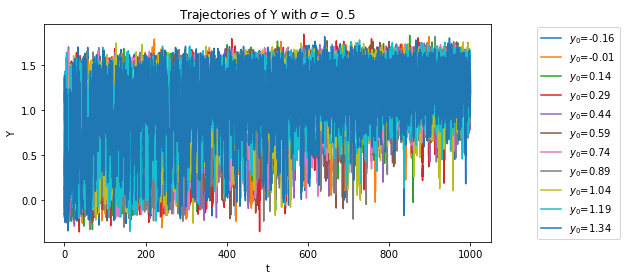

In [29]:
sigma = 0.5  # Standard deviation

T = 1000.  # Total time.
n = int(T / dt)  # Number of time steps.
t = np.linspace(0., T, n)  # Vector of times.

fig, ax = plt.subplots(1, 1, figsize=(8, 4))          # initialize plot

ivs = np.arange(-0.16,1.46,step=0.15)
for k,iv in enumerate(ivs):
    x = np.ones(n)*iv
    for i in range(n - 1):
        x[i+1] = x[i] + (F-x[i]*(1+mu*(1-x[i])**2))*dt \
            + F*eps*t[i]*dt \
            + F*sigma*sqrtdt*np.random.randn()
    plt.plot(t,x,label = "$y_0$={:.2f}".format(iv))

plt.xlabel("t")
plt.ylabel("Y")
plt.title("Trajectories of Y with $\sigma=$ {}".format(sigma))
plt.legend(loc="right",bbox_to_anchor=(0.8, 0., 0.5, 1.0));

Fokker-Plank equation for the autonomous case for different time points:

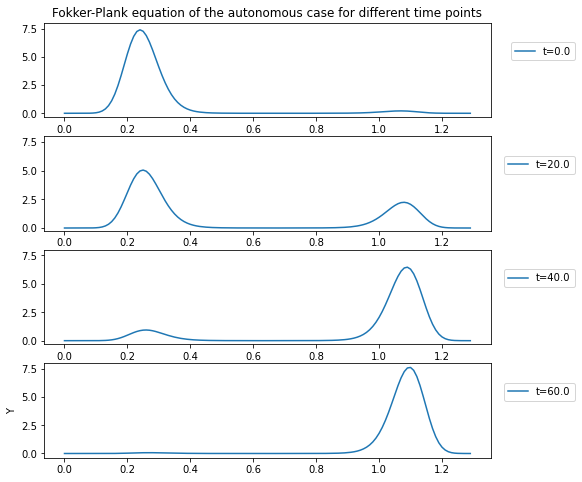

In [30]:
sigma=0.1
fig, ax = plt.subplots(4, 1, figsize=(8, 8))


plt.subplot(411)
t=0.00
plt.plot(y,FP(y,sigma,t),label="t={}".format(t/eps))
plt.ylim(top=8)
plt.legend(loc="right",bbox_to_anchor=(0.7, 0.2, 0.5, 1.0))
plt.title("Fokker-Plank equation of the autonomous case for different time points")

plt.subplot(412)
t=0.02
plt.plot(y,FP(y,sigma,t),label="t={}".format(t/eps))
plt.ylim(top=8)
plt.legend(loc="right",bbox_to_anchor=(0.7, 0.2, 0.5, 1.0))

plt.subplot(413)
t=0.04
plt.plot(y,FP(y,sigma,t),label="t={}".format(t/eps))
plt.ylim(top=8)
plt.legend(loc="right",bbox_to_anchor=(0.7, 0.2, 0.5, 1.0))

plt.subplot(414)
t=0.06
plt.plot(y,FP(y,sigma,t),label="t={}".format(t/eps))
plt.ylim(top=8)
plt.ylabel("Y")
plt.legend(loc="right",bbox_to_anchor=(0.7, 0.2, 0.5, 1.0));
